In [1]:
import torch
import numpy as np
import torch.nn as nn
import pickle
import random
from torch.utils.data import DataLoader
import datetime

In [2]:
random.seed(0)

In [3]:
class Autoencoder_spectrum(nn.Module):
    def __init__(self,input_dim,spectrum_dim,num_hidden_layers=3,num_hidden_dimensions=256):
        super(Autoencoder_spectrum,self).__init__()
        self.num_hidden_layers=num_hidden_layers
        
        self.encoder=nn.ModuleList([nn.Linear(input_dim,num_hidden_dimensions),nn.ReLU()])
        self.decoder=nn.ModuleList([nn.Linear(spectrum_dim,num_hidden_dimensions),nn.ReLU()])
        for i in range(num_hidden_layers-1):
            self.encoder.append(nn.Linear(num_hidden_dimensions,num_hidden_dimensions))
            self.encoder.append(nn.ReLU())
            self.encoder.append(nn.Dropout())
            self.decoder.append(nn.Linear(num_hidden_dimensions,num_hidden_dimensions))
            self.decoder.append(nn.ReLU())
            self.decoder.append(nn.Dropout())
        self.encoder.append(nn.Linear(num_hidden_dimensions,spectrum_dim))
        self.encoder.append(nn.ReLU())
        self.decoder.append(nn.Linear(num_hidden_dimensions,input_dim))
        self.decoder.append(nn.ReLU())
        
    def forward(self,in_vals):
        for modules in self.encoder:
            in_vals=modules(in_vals)
        spectrum_result=in_vals
        for modules in self.decoder:
            in_vals=modules(in_vals)
        return in_vals,spectrum_result
    
    def encode(self,in_vals):
        for modules in self.encoder:
            in_vals=modules(in_vals)
        return in_vals
    
    def decode(self,code):
        for modules in self.decoder:
            code=modules(code)
        return code

In [4]:
NUM_HIDDEN_LAYERS=3
NUM_HIDDEN_DIMENSIONS=512
LEARNING_RATE_INIT=0.001
RHO=0.5
use_device='cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
with open('config_data.pickle','rb+') as f:
    configs=pickle.load(f)
with open('rdf_data.pickle','rb+') as f:
    rdf=pickle.load(f)

In [6]:
for i in range(len(configs)):
    configs[i]=torch.flatten(torch.tensor(configs[i],dtype=torch.float32))
    rdf[i]=torch.tensor(rdf[i],dtype=torch.float32)

In [7]:
temp=list(zip(configs,rdf))
random.shuffle(temp)
configs,rdf=zip(*temp)

In [8]:
class RDFDataset(torch.utils.data.Dataset):
    def __init__(self,configs,rdf):
        super(RDFDataset,self).__init__()
        self.configs=configs
        self.rdf=rdf
        
    def __len__(self):
        return len(self.rdf)
    
    def __getitem__(self,index):
        ind_config=self.configs[index]
        ind_rdf=self.rdf[index]
        return ind_config,ind_rdf

In [9]:
batch_num=20 #The batch size for mini-batch stochastic gradient descent. It should be modified accroding to the size of the model and the RAM of the graphics card
is_pin_memory=False

data_size=len(configs)

train_size=int(data_size*0.6)
valid_size=int(data_size*0.2)
test_size=data_size-train_size-valid_size

train_dataset=RDFDataset(configs[:train_size],rdf[:train_size])
valid_dataset=RDFDataset(configs[train_size:train_size+valid_size],rdf[train_size:train_size+valid_size])
test_dataset=RDFDataset(configs[train_size+valid_size:],rdf[train_size+valid_size:])

train_dataloader=DataLoader(train_dataset,batch_size=batch_num,pin_memory=is_pin_memory) 
valid_dataloader=DataLoader(valid_dataset,batch_size=batch_num,pin_memory=is_pin_memory)
test_dataloader=DataLoader(test_dataset,batch_size=batch_num,pin_memory=is_pin_memory)

In [10]:
model=Autoencoder_spectrum(input_dim=configs[0].shape[0],spectrum_dim=rdf[0].shape[0])
model.to(use_device)
optimizer=torch.optim.Adam(model.parameters(),lr=LEARNING_RATE_INIT)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.8)

In [11]:
min_valid_error=np.inf
train_errors=list()
valid_errors=list()
cnt=0
for i in range(200):
    time_beg_epoch=datetime.datetime.now()

    #training process
    model.train()
    train_error=0
    for train_batch,true_spectrum in train_dataloader:
        train_batch=train_batch.to(use_device)
        true_spectrum=true_spectrum.to(use_device)
        optimizer.zero_grad()
        reconstruct_val,encode_spectrum=model(train_batch)
        loss_energy=torch.nn.functional.mse_loss(reconstruct_val,train_batch,reduction='none')
        loss_spectrum=torch.nn.functional.mse_loss(encode_spectrum,true_spectrum,reduction='none')
        total_loss=RHO*torch.sum(loss_energy,dim=1)+(1-RHO)*torch.sum(loss_spectrum,dim=1)
        total_loss.backward(torch.ones_like(total_loss))
        optimizer.step()
        train_error+=torch.sum(total_loss).cpu().detach().numpy()
    train_errors.append(train_error/train_size)

    #validation process
    model.eval()
    valid_error=0
    for valid_batch,true_spectrum in valid_dataloader:
        valid_batch=valid_batch.to(use_device)
        true_spectrum=true_spectrum.to(use_device)
        optimizer.zero_grad()
        reconstruct_val,encode_spectrum=model(valid_batch)
        loss_energy=torch.nn.functional.mse_loss(reconstruct_val,valid_batch,reduction='none')
        loss_spectrum=torch.nn.functional.mse_loss(encode_spectrum,true_spectrum,reduction='none')
        total_loss=RHO*torch.sum(loss_energy,dim=1)+(1-RHO)*torch.sum(loss_spectrum,dim=1)
        valid_error+=torch.sum(total_loss).cpu().detach().numpy()
    valid_errors.append(valid_error/valid_size)

    #print information & judgement for early stopping
    scheduler.step()
    time_end_epoch=datetime.datetime.now()
    print('Epoch ',i,' training error = ',train_error/train_size,
          ' validation error = ',valid_error/valid_size,
          ' training and validation time = ',time_end_epoch-time_beg_epoch)

    if valid_error<min_valid_error: #judgement for early stopping
        cnt=0
        torch.save(model,'best_model.pkl')
        min_valid_error=valid_error
    else:
        cnt+=1
        if cnt>=10:
            print('Early stopping')
            del(model)
            with open('training_errors.pickle','wb') as f:
                pickle.dump(train_errors,f)
            with open('valid_errors.pickle','wb') as f:
                pickle.dump(valid_errors,f)
            break

Epoch  0  training error =  588.5685923728821  validation error =  313.71570940204697  training and validation time =  0:00:15.382440


D:\software\Anaconda\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Autoencoder_XAFS. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\software\Anaconda\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\software\Anaconda\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\software\Anaconda\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\software\Anaconda

Epoch  1  training error =  337.5752398086796  validation error =  269.3530948713714  training and validation time =  0:00:14.684168
Epoch  2  training error =  305.34550167962857  validation error =  255.92001303878484  training and validation time =  0:00:14.647040
Epoch  3  training error =  290.64795795568756  validation error =  248.16562329460592  training and validation time =  0:00:14.634908
Epoch  4  training error =  279.13106625431277  validation error =  267.1177242503447  training and validation time =  0:00:14.615770
Epoch  5  training error =  265.58904636327895  validation error =  221.6735294416839  training and validation time =  0:00:14.485342
Epoch  6  training error =  259.4993203294578  validation error =  216.22129205441942  training and validation time =  0:00:14.751690
Epoch  7  training error =  254.7324773213334  validation error =  214.55362494973576  training and validation time =  0:00:14.480482
Epoch  8  training error =  250.30381832305108  validation er

Epoch  62  training error =  193.63748325696616  validation error =  157.00894631030513  training and validation time =  0:00:15.306094
Epoch  63  training error =  193.44434005416946  validation error =  157.06785960477941  training and validation time =  0:00:15.634535
Epoch  64  training error =  193.9614512603488  validation error =  156.68324558033663  training and validation time =  0:00:15.743866
Epoch  65  training error =  192.85751779339844  validation error =  156.60220163382735  training and validation time =  0:00:15.753871
Epoch  66  training error =  193.12806497291356  validation error =  157.75407364789177  training and validation time =  0:00:15.848672
Epoch  67  training error =  192.88939838083766  validation error =  156.12258068907494  training and validation time =  0:00:15.450220
Epoch  68  training error =  192.99935477610245  validation error =  156.01667054868213  training and validation time =  0:00:15.711543
Epoch  69  training error =  192.7604608531871  v

NameError: name 'model_init' is not defined

In [13]:
final_model=torch.load('best_model.pkl')
final_model=final_model.to(use_device)
final_model.eval()
reconstructions=list()
pred_spectrums=list()
true_configs=list()
true_spectrums=list()
for test_data,test_spectrum in test_dataloader:
    test_data=test_data.to(use_device)
    test_spectrum=test_spectrum.to(use_device)
    pred_reconstruct,pred_spectrum=final_model(test_data)

    reconstructions.append(pred_reconstruct.cpu().detach().numpy())
    pred_spectrums.append(pred_spectrum.cpu().detach().numpy())
    true_configs.append(test_data.cpu().detach().numpy())
    true_spectrums.append(test_spectrum.cpu().detach().numpy())
    
reconstructions=np.concatenate(reconstructions,axis=0)
pred_spectrums=np.concatenate(pred_spectrums,axis=0)
true_configs=np.concatenate(true_configs,axis=0)
true_spectrums=np.concatenate(true_spectrums,axis=0)

In [16]:
import matplotlib.pyplot as plt

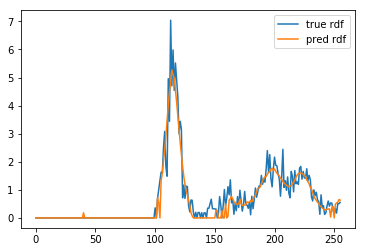

In [34]:
fig1=plt.figure()
ax=fig1.add_subplot(1,1,1)
ax.plot(true_spectrums[720],label='true rdf')
ax.plot(pred_spectrums[720],label='pred rdf')
ax.legend()

In [24]:
import seaborn as sns

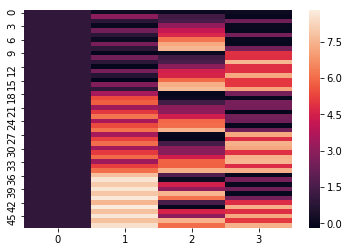

In [30]:
sns.heatmap(np.reshape(true_configs[300],(-1,4)))

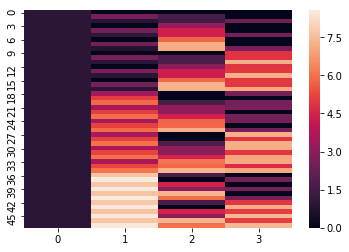

In [31]:
sns.heatmap(np.reshape(reconstructions[300],(-1,4)))

In [ ]:
with open('reconstructions_test.pickle','wb') as f:
    pickle.dump(reconstructions,f)
with open('pred_spectrums.pickle','wb') as f:
    pickle.dump(pred_spectrums,f)